# Gradient boosting, random forests, decision trees

This notebook demonstrates our implementation of classification and regression **decision trees**, **random forests** and **gradient boosted regression trees**.

We test our algorithms on two classic datasets:

#### Classification for the KDDCUP99 dataset

- Classification decision tree and random forest
- Evaluation of algorithm performance using ROC curves and F1 scores (also implemented from scratch)
- SMOTETomek algorithm before training to address class imbalance of the dataset

#### Regression for the California housing dataset

- Regression decision tree and gradient boosting
- Evaluation of algorithm performance using mean squared error and histograms

For the sake of simplicity, in this notebook we split data into a training and test set. The test set more accurately serves the purpose of a validation set here.

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_california_housing, fetch_kddcup99
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.combine import SMOTETomek
from sklearn.model_selection import train_test_split

Importing our models...

In [2]:
from decisiontree import decisionTreeClassifier
from decisiontree import decisionTreeRegressor
from gradientboosting import gradientBoostedRegressionTree
from randomforest import randomForestClassifier
from metrics import *

## Classification using random forest and decision trees

### Loading the KDDCUP99 dataset and preprocessing

The KDDCUP99 dataset was part of a competition to build a network intrusion detector. It is highly imbalanced (more 'normal' network activity than malicious activity).

In [3]:
kddcup = fetch_kddcup99(subset='SF',as_frame=True)
X_unencoded = kddcup.data
Y_unencoded = kddcup.target

The 'service' column in X contains data encoded as bytes - we encode the entries of this column as integers. Similarly, Y contains information about the type of activity encoded in bytes. We put all malicous network activity into one category. Therefore we only distinguish between normal activity and malicious activity instead of the different subtypes of malicious activity.

In [4]:
def encodeBytes(X):
    encoding = dict(zip(X.unique(),range(len(X.unique()))))
    return X.map(encoding)
# Encoding the service column of X
X = X_unencoded.copy()
X.loc[:,'service'] = encodeBytes(X.service)
# Creating two target categories
Y = Y_unencoded.map(lambda y : 'normal' if y==b'normal.' else 'malicious')

The dataset is highly imbalanced, malicious activity only makes up a small fraction of the entire dataset. We use SMOTETomek resampling to synthesise a new balanced dataset. The class imbalance also means we will be more interested in the recall and F1 scores as measures of performance.

In [5]:
smt = SMOTETomek(sampling_strategy='auto')
X_smt, Y_smt = smt.fit_resample(X, Y)

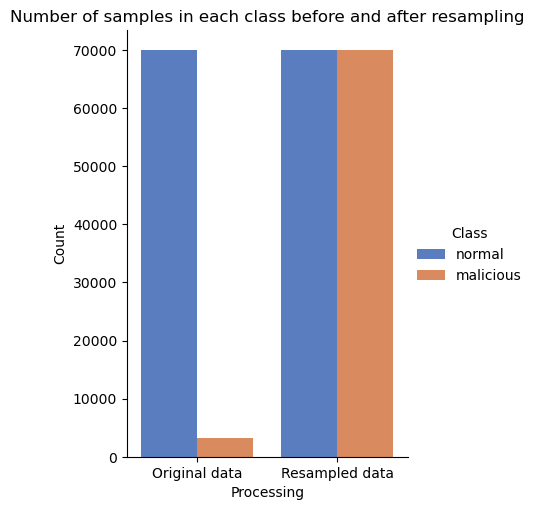

In [6]:
# Dataframe for plotting
df = pd.DataFrame([Y.value_counts(),Y_smt.value_counts()])
df['Processing'] = ['Original data', 'Resampled data']
df = pd.melt(df, id_vars = 'Processing', var_name = 'Class', value_name = 'Count')
# Plotting
sns.set_palette('muted')
ax = sns.catplot(x='Processing', y='Count', hue='Class', data=df, kind='bar', aspect = 0.8)
plt.title('Number of samples in each class before and after resampling')
plt.show()

Finally, we split the balanced dataset into a training and testing set.

In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(X_smt,Y_smt,test_size=0.1)

### Learning a decision tree

We begin by learning a simple classification decision tree.

In [8]:
learner = decisionTreeClassifier(X_train,Y_train,max_depth = 4)
learner.learn()

We calculate the F1 scores and recall for both the (synthetic) testing set and the original dataset. These metrics are defined in the metrics.py file and accept a trained model together with a dataset to evaluate.

In [9]:
print('On the (resampled) testing dataset...')
r  = recall(learner,X_test,Y_test)
f1 = F1(learner,X_test,Y_test)
print(f"Recall for normal activity:\t{r['normal']:.2f} \t F1 score for normal activity:\t\t{f1['normal']:.2f}")
print(f"Recall for malicious activity:\t{r['malicious']:.2f} \t F1 score for malicious activity:\t{f1['malicious']:.2f}")
print('---------------------------------')
print('On the (original) full dataset...')
r  = recall(learner,X,Y)
f1 = F1(learner,X,Y)
print(f"Recall for normal activity:\t{r['normal']:.2f} \t F1 score for normal activity:\t\t{f1['normal']:.2f}")
print(f"Recall for malicious activity:\t{r['malicious']:.2f} \t F1 score for malicious activity:\t{f1['malicious']:.2f}")

On the (resampled) testing dataset...
Recall for normal activity:	0.97 	 F1 score for normal activity:		0.97
Recall for malicious activity:	0.98 	 F1 score for malicious activity:	0.97
---------------------------------
On the (original) full dataset...
Recall for normal activity:	0.97 	 F1 score for normal activity:		0.98
Recall for malicious activity:	0.98 	 F1 score for malicious activity:	0.73


We observe that the F1 score for malicious activity is weaker for the original dataset (however it is still better than what one could obtain without using SMOTETomek before training).

### Learning a random forest

Next we learn a random forest! The parameters were chosen by some experimentation, in practice it would be wise to conduct a hyperparameter search.

In [10]:
learner = randomForestClassifier(X_train,Y_train,
                                 num_trees=15,
                                 max_depth=3,
                                 feature_fraction=0.75)
learner.learn()

100%|███████████████████████████████████████████| 15/15 [00:16<00:00,  1.11s/it]


We evaluate the performance of our random forest by plotting a ROC curve! The corresponding method is again defined in metrics.py.

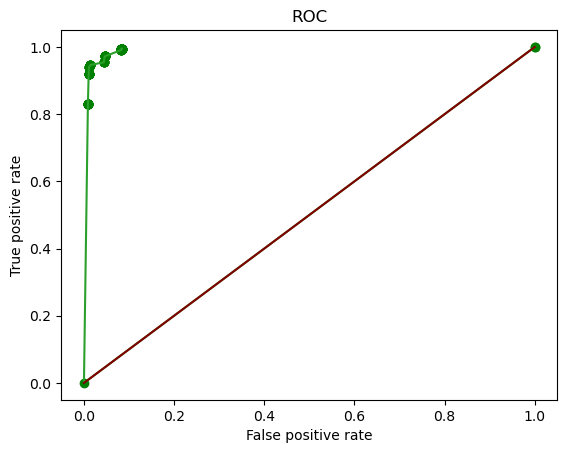

In [11]:
roc(learner,X_test,Y_test,'malicious')

As above, we consider the F1 scores and recall on both the testing set and the original dataset.

In [12]:
print('On the (resampled) testing dataset...')
r  = recall(learner,X_test,Y_test)
f1 = F1(learner,X_test,Y_test)
print(f"Recall for normal activity:\t{r['normal']:.2f} \t F1 score for normal activity:\t\t{f1['normal']:.2f}")
print(f"Recall for malicious activity:\t{r['malicious']:.2f} \t F1 score for malicious activity:\t{f1['malicious']:.2f}")
print('---------------------------------')
print('On the (original) full dataset...')
r  = recall(learner,X,Y)
f1 = F1(learner,X,Y)
print(f"Recall for normal activity:\t{r['normal']:.2f} \t F1 score for normal activity:\t\t{f1['normal']:.2f}")
print(f"Recall for malicious activity:\t{r['malicious']:.2f} \t F1 score for malicious activity:\t{f1['malicious']:.2f}")

On the (resampled) testing dataset...
Recall for normal activity:	0.96 	 F1 score for normal activity:		0.96
Recall for malicious activity:	0.95 	 F1 score for malicious activity:	0.95
---------------------------------
On the (original) full dataset...
Recall for normal activity:	0.96 	 F1 score for normal activity:		0.98
Recall for malicious activity:	0.95 	 F1 score for malicious activity:	0.67


In this case the random forest and decision tree models do not perform significantly different.

## Regression using gradient boosted trees

### Importing the California housing dataset

In [13]:
housing = fetch_california_housing(as_frame=True)
X = housing.data
Y = housing.target

We split into a training and testing (or more accurately, validation) set.

In [14]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.3)

### Learning a decision tree

In [15]:
learner = decisionTreeRegressor(X_train, Y_train, max_depth=10)
learner.learn()
Ypred_test_tree = learner.predict(X_test) # Save for histogram

We compute the MSE on the training and test sets:

In [16]:
mse_train = learner.mse
mse_test  = ((Ypred_test_tree-Y_test)**2).mean()
print(f'MSE on training set: {mse_train:.2f}\t MSE on test set: {mse_test:.2f}')

MSE on training set: 0.45	 MSE on test set: 0.49


### Learning a gradient boosted tree

We plot the MSE as a function of the number of models for various choices of learning rates. Even though the learning rate of 1.0 has the minimum error at the end of a few iterations, it is better to choose a smaller learning rate and higher number of models to prevent overfitting.

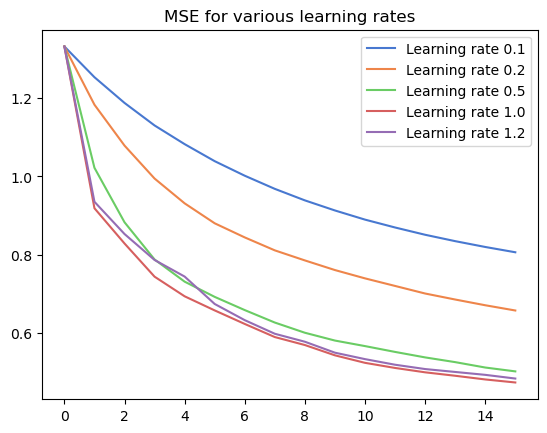

In [17]:
rates = [0.1, 0.2, 0.5, 1.0, 1.2]
for rate in rates:
    learner = gradientBoostedRegressionTree(X, Y, num_models = 15, learning_rate = rate)
    learner.learn(show_progress_bar=False)
    plt.plot(learner.mse_history, label = f'Learning rate {rate}')
plt.legend()
plt.title('MSE for various learning rates')
plt.show()

100%|███████████████████████████████████████████| 20/20 [00:10<00:00,  1.92it/s]


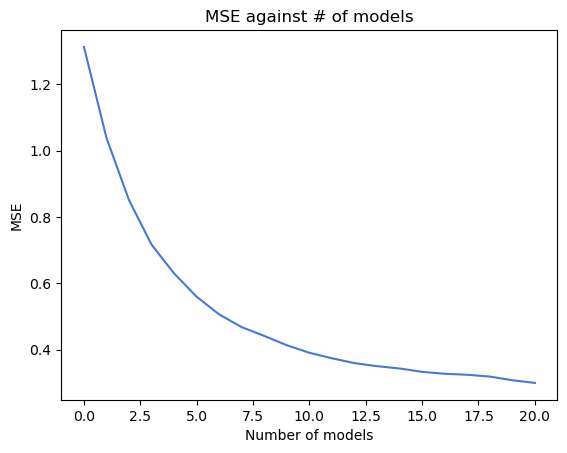

In [18]:
learner = gradientBoostedRegressionTree(X_train,Y_train,
                                        num_models= 20,
                                        tree_depth = 5,
                                        learning_rate = 0.2)
learner.learn()
learner.plot_mse_history()
Ypred_test_gbm = learner.predict(X_test) # Save for histogram

In [19]:
mse_train = learner.mse
mse_test  = ((Ypred_test_gbm-Y_test)**2).mean()
print(f'MSE on training set: {mse_train:.2f}\t MSE on test set: {mse_test:.2f}')

MSE on training set: 0.30	 MSE on test set: 0.33


### Comparing the models visually

We compare the decision tree and gradient boosted trees from above on the testing set by plotting a histogram.

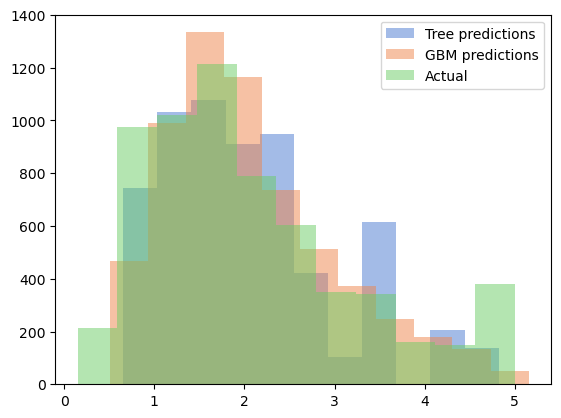

In [20]:
plt.hist(Ypred_test_tree, bins = 11, alpha = 0.5, label = 'Tree predictions')
plt.hist(Ypred_test_gbm, bins = 11, alpha = 0.5, label = 'GBM predictions')
plt.hist(Y_test, bins = 11, alpha = 0.5, label = 'Actual')
plt.legend()
plt.show()

We conclude that the gradient boosted model both has lower MSE scores on training and testing datasets, and provides a better overall fit to the distribution.